In [1]:
! mkdir ~/.kaggle

In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [02:27<00:00, 43.8MB/s]
100% 5.20G/5.20G [02:27<00:00, 37.7MB/s]


In [5]:
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [8]:
!pip install efficientnet_pytorch torchtoolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached efficientnet_pytorch-0.7.1.tar.gz (21 kB)
  Preparing metadata (setup.py) ... done
  Using cached torchtoolbox-0.1.8.2-py3-none-any.whl (84 kB)
  Using cached lmdb-1.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (299 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.6 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=a6070c9ee89c3528ff05ce281d05dfa6a34e8d81ca74140c1d2786603aba067a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [9]:
import torch
import torchvision
from torchvision import models,transforms

import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet

from sklearn.model_selection import train_test_split

import torch.nn.functional as F

%matplotlib inline

In [10]:
# At least fixing some random seeds. 
# It is still impossible to make results 100% reproducible when using GPU
warnings.simplefilter('ignore')
torch.manual_seed(47)
np.random.seed(47)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, train: bool = True, transforms = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            
        """
        self.df = df
        self.path1 = '/content/HAM10000_images_part_1'
        self.path2 = '/content/HAM10000_images_part_2'
        # self.path1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
        # self.path2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
        self.transforms = transforms
        self.train = train
        
    def __getitem__(self, index):
        
        image_path = os.path.join(self.path1, self.df.iloc[index]['image_id'] + '.jpg')
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
        else:
            # If the image is not in part 1, try to load it from part 2
            image_path = os.path.join(self.path2, self.df.iloc[index]['image_id'] + '.jpg')
            if os.path.exists(image_path):
                image = cv2.imread(image_path)

        if self.transforms:
            x = self.transforms(image)
            
        if self.train:
            y = self.df.loc[index]['target']
            return x, y
        else:
            return x
    
    def __len__(self):
        return len(self.df)
    
    def _get_label(self, dataset, idx):
        return self.df.iloc[idx]['target']
    
    


In [13]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.RandomResizedCrop(size=240, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])


In [15]:
df = pd.read_csv('/content/HAM10000_metadata.csv')
# df = pd.read_csv('/content/metadata_ABCD.csv')


# this will tell us how many images are associated with each lesion_id
df_undup = df.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)

def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df['duplicates'] = df['lesion_id']
# apply the function to this new column
df['duplicates'] = df['duplicates'].apply(get_duplicates)

df_undup  = df[df['duplicates'] == 'unduplicated']

#now we create a test set using df_undup because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['dx']
_, test_df_csv = train_test_split(df_undup, test_size=0.7265, random_state=101, stratify=y)
test_df_csv.shape

# This set will be df_original excluding all rows that are in the test set
# This function identifies if an image is part of the train or test set.
def get_test_rows(x):
    # create a list of all the lesion_id's in the val test
    test_list = list(test_df_csv['image_id'])
    if str(x) in test_list:
        return 'test'
    else:
        return 'train'

# identify train and test rows
# create a new colum that is a copy of the image_id column
df['train_or_test'] = df['image_id']
# apply the function to this new column
df['train_or_test'] = df['train_or_test'].apply(get_test_rows)
# filter out train rows
train_df_csv = df[df['train_or_test'] == 'train']

# Split the test into 50% test and 50% validation
test_df, val_df = train_test_split(test_df_csv, test_size=0.5, random_state=101, stratify=test_df_csv['dx'])

train_df = train_df_csv
print(len(train_df))
print(len(val_df))
print(len(test_df))

6009
2003
2003


In [16]:
train_df.dx.value_counts()

nv       3497
mel       946
bkl       779
bcc       387
akiec     217
vasc       96
df         87
Name: dx, dtype: int64

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['target'] = le.fit_transform(train_df['dx'])
val_df['target'] = le.fit_transform(val_df['dx'])
test_df['target'] = le.fit_transform(test_df['dx'])

In [18]:
train_df.target.value_counts()

5    3497
4     946
2     779
1     387
0     217
6      96
3      87
Name: target, dtype: int64

In [19]:
# from collections import Counter
# from sklearn.utils import resample

# # Count the number of samples for each class
# class_counts = Counter(train_df['target'])

# # Get the size of the majority class
# majority_class_size = max(class_counts.values())

# # Oversample minority classes to match the size of the majority class
# for class_label, class_size in class_counts.items():
#     if class_label != train_df['target'].mode()[0]:
#         # Determine the number of times to resample the class
#         resample_rate = int(majority_class_size / class_size)
        
#         X_subset = train_df[train_df['target'] == class_label].drop(['target'], axis=1)
#         y_subset = train_df[train_df['target'] == class_label]['target']
        
#         # Resample the class with replacement
#         X_subset_resampled, y_subset_resampled = resample(X_subset, y_subset, 
#                                                           replace=True, n_samples=(resample_rate-1)*class_size, 
#                                                           random_state=42)
        
#         # Concatenate the resampled data with the original data
#         train_df = pd.concat([train_df, pd.concat([X_subset_resampled, y_subset_resampled], axis=1)])

# # Verify that all classes have the same number of samples
# print(train_df['target'].value_counts())


In [20]:
train_df['sex'] = train_df['sex'].map({'male': 1, 'female': 0})
val_df['sex'] = val_df['sex'].map({'male': 1, 'female': 0})
test_df['sex'] = test_df['sex'].map({'male': 1, 'female': 0})

train_df['sex'] = train_df['sex'].fillna(-1)
val_df['sex'] = val_df['sex'].fillna(-1)
test_df['sex'] = test_df['sex'].fillna(-1)


In [21]:
train_df = pd.get_dummies(train_df, columns=['localization'],prefix='site')
val_df = pd.get_dummies(val_df, columns=['localization'],prefix='site')

test_df = pd.get_dummies(test_df, columns=['localization'],prefix='site')

# adding missing cols to val and test sets
val_df = val_df.reindex(columns=train_df.columns, fill_value=0)
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

In [22]:
test = MelanomaDataset(df=test_df,
                       train=False,
                       transforms=test_transform)

In [23]:
    
class Net(nn.Module):
    def __init__(self,b1 = False, b4 = False):
        super(Net, self).__init__()
        self.b1 = b1
        self.b4 = b4
        if self.b1:
            self.arch = EfficientNet.from_pretrained('efficientnet-b1')
            self.arch._fc = nn.Linear(in_features=1280, out_features=7, bias=True)
            
        elif self.b4:
            self.arch = EfficientNet.from_pretrained('efficientnet-b4')
            self.arch._fc = nn.Linear(in_features=1792, out_features=7, bias=True)

        
    def forward(self, x):
        x = self.arch(x)
        return x

In [ ]:
# class Net(nn.Module):
#     def __init__(self,b1 = False, b4 = False):
#         super(Net, self).__init__()
#         self.b1 = b1
#         self.b4 = b4
        
#         if self.b1:
#             self.features = EfficientNet.from_pretrained('efficientnet-b1')
#             self.classification = nn.Sequential(nn.Linear(1280, 7))  
#         elif self.b4:
#             self.features = EfficientNet.from_pretrained('efficientnet-b4')
#             self.classification = nn.Sequential(nn.Linear(1792, 7))  

        
#     def forward(self, x):
#         x = self.features.extract_features(x)
        
#         if self.b1:
#             x = F.avg_pool2d(x, x.size()[2:]).reshape(-1, 1280)
#         elif self.b4:
#             x = F.avg_pool2d(x, x.size()[2:]).reshape(-1, 1792)       
        
#         out = self.classification(x)
        # return out

In [24]:
epochs = 10  # Number of epochs to run
model_path = 'model.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation 

oof = np.zeros((len(train_df), 7))  # Out Of Fold predictions


In [25]:
from tqdm import tqdm
import tqdm.notebook as tq
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

In [26]:
# Define Focal loss implementation
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction=self.reduction, weight=self.alpha)
        pt = torch.exp(-CE_loss)
        F_loss = ((1-pt)**self.gamma) * CE_loss
        if self.reduction == 'mean': return F_loss.mean()
        else: return F_loss.sum()

In [27]:

best_val = None  # Best validation score within this fold
patience = es_patience  # Current patience counter
#     arch = EfficientNet.from_pretrained('efficientnet-b1')
#     arch = models.resnet50(pretrained=True)


model = Net(b1=True)  # New model for each fold
model = model.to(device)

#giving more importance to mel

# Define weight factors
class_factor_interest = 2.0
class_factor_minority = 1.0
class_factor_majority = 0.5

# Get class labels and weights
class_labels = np.unique(train_df['target'])
class_weights_all = compute_class_weight('balanced', classes=class_labels, y=train_df['target'])

# Modify class weights to reflect weight factors
class_weights = np.zeros_like(class_weights_all)
for i, weight in enumerate(class_weights_all):
    if class_labels[i] == 4:  # class of interest
        class_weights[i] = weight * class_factor_interest
    elif weight == np.max(class_weights_all):  # majority class
        class_weights[i] = weight * class_factor_majority
    else:  # minority class
        class_weights[i] = weight * class_factor_minority

# Convert class weights to PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Initialize Focal loss object
focal_loss = FocalLoss(gamma=2, alpha=class_weights)


optim = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.4)
criterion = nn.CrossEntropyLoss(weight=class_weights)

train = MelanomaDataset(df=train_df.reset_index(drop=True), 
                        train=True, 
                        transforms=train_transform)
val = MelanomaDataset(df=val_df.reset_index(drop=True), 
                        train=True, 
                        transforms=test_transform)

train_loader = DataLoader(dataset=train, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=test, batch_size=8, shuffle=False, num_workers=0)

for epoch in tqdm(range(epochs)):
    start_time = time.time()
    correct = 0
    epoch_loss = 0
    model.train()

    for x, y in tq.tqdm(train_loader):
        x = torch.tensor(x, device=device, dtype=torch.float32)
        y = torch.tensor(y, device=device, dtype=torch.long)
        optim.zero_grad()
        z = model(x)
        loss =  focal_loss(z, y)
        # loss =  criterion(z, y)
        loss.backward()
        optim.step()
        pred = torch.argmax(z, dim=1)  # get the index of the highest value in out
        correct += (pred.cpu() == y.cpu()).sum().item()  # tracking number of correctly predicted samples
        epoch_loss += loss.item()
    train_acc = correct / len(train_df)

    model.eval()  # switch model to the evaluation mode
    val_preds = torch.zeros((len(val_df), 7), dtype=torch.float32, device=device)
    with torch.no_grad():  # Do not calculate gradient since we are only predicting
        # Predicting on validation set
        for j, (x_val, y_val) in enumerate(val_loader):
            x_val = torch.tensor(x_val, device=device, dtype=torch.float32)
            y_val = torch.tensor(y_val, device=device, dtype=torch.long)
            z_val = model(x_val)
            val_pred = torch.softmax(z_val, dim=1) # use softmax to convert logits to probabilities
            val_preds[j*x_val.shape[0]:j*x_val.shape[0] + x_val.shape[0]] = val_pred

        val_preds = torch.softmax(val_preds, dim=1) # use softmax to convert logits to probabilities
        val_acc = accuracy_score(val_df['target'].values, torch.argmax(val_preds.cpu(), dim=1))
        val_preds = val_preds.cpu().detach().numpy()
        val_preds = val_preds.reshape(-1, 7) # reshape val_preds to a 2D tensor

        val_roc = roc_auc_score(val_df['target'].values, val_preds, multi_class='ovr')


        print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
        epoch + 1, 
        epoch_loss/len(train_loader), 
        train_acc, 
        val_acc, 
        val_roc, 
        str(datetime.timedelta(seconds=time.time() - start_time))[:7]))

        scheduler.step(val_roc)
        # During the first iteration (first epoch) best validation is set to None
        if not best_val:
            best_val = val_roc  # So any validation roc_auc we have is the best one for now
            torch.save(model, model_path)  # Saving the model
            continue

        if val_roc >= best_val:
            best_val = val_roc
            patience = es_patience  # Resetting patience since we have new best validation accuracy
            torch.save(model, model_path)  # Saving current best model
        else:
            patience -= 1
            if patience == 0:
                print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                break



Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 49.3MB/s]


Loaded pretrained weights for efficientnet-b1


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/376 [00:00<?, ?it/s]

 10%|█         | 1/10 [06:33<59:05, 393.96s/it]

Epoch 001: | Loss: 0.743 | Train acc: 0.460 | Val acc: 0.830 | Val roc_auc: 0.961 | Training time: 0:06:33


  0%|          | 0/376 [00:00<?, ?it/s]

 20%|██        | 2/10 [12:59<51:51, 389.00s/it]

Epoch 002: | Loss: 0.269 | Train acc: 0.659 | Val acc: 0.830 | Val roc_auc: 0.960 | Training time: 0:06:25


  0%|          | 0/376 [00:00<?, ?it/s]

 30%|███       | 3/10 [19:24<45:10, 387.26s/it]

Epoch 003: | Loss: 0.174 | Train acc: 0.703 | Val acc: 0.847 | Val roc_auc: 0.967 | Training time: 0:06:25


  0%|          | 0/376 [00:00<?, ?it/s]

 40%|████      | 4/10 [25:49<38:38, 386.49s/it]

Epoch 004: | Loss: 0.109 | Train acc: 0.753 | Val acc: 0.872 | Val roc_auc: 0.969 | Training time: 0:06:25


  0%|          | 0/376 [00:00<?, ?it/s]

 50%|█████     | 5/10 [32:15<32:10, 386.01s/it]

Epoch 005: | Loss: 0.071 | Train acc: 0.776 | Val acc: 0.917 | Val roc_auc: 0.977 | Training time: 0:06:25


  0%|          | 0/376 [00:00<?, ?it/s]

 60%|██████    | 6/10 [38:40<25:42, 385.71s/it]

Epoch 006: | Loss: 0.064 | Train acc: 0.787 | Val acc: 0.871 | Val roc_auc: 0.973 | Training time: 0:06:25


  0%|          | 0/376 [00:00<?, ?it/s]

 70%|███████   | 7/10 [45:06<19:17, 385.91s/it]

Epoch 007: | Loss: 0.046 | Train acc: 0.826 | Val acc: 0.838 | Val roc_auc: 0.965 | Training time: 0:06:26
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.


  0%|          | 0/376 [00:00<?, ?it/s]

 80%|████████  | 8/10 [51:33<12:52, 386.31s/it]

Epoch 008: | Loss: 0.029 | Train acc: 0.838 | Val acc: 0.906 | Val roc_auc: 0.979 | Training time: 0:06:27


  0%|          | 0/376 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [58:02<06:27, 387.11s/it]

Epoch 009: | Loss: 0.026 | Train acc: 0.848 | Val acc: 0.916 | Val roc_auc: 0.976 | Training time: 0:06:28


  0%|          | 0/376 [00:00<?, ?it/s]

100%|██████████| 10/10 [1:04:29<00:00, 386.98s/it]

Epoch 010: | Loss: 0.021 | Train acc: 0.859 | Val acc: 0.877 | Val roc_auc: 0.976 | Training time: 0:06:27
Epoch 00010: reducing learning rate of group 0 to 1.6000e-05.


In [28]:
test_loader = DataLoader(dataset=test, batch_size=8, shuffle=False,num_workers=0)

In [29]:
test_df.dx.value_counts()

nv       1604
bkl       160
mel        83
bcc        64
akiec      55
vasc       23
df         14
Name: dx, dtype: int64

In [30]:
model = torch.load('./model.pth')
model.eval()  # switch model to the evaluation mode
preds = torch.zeros((len(test), 7), dtype=torch.float32, device=device)
with torch.no_grad():

  for i, x_test in enumerate(test_loader):  
      x_test = torch.tensor(x_test, device=device, dtype=torch.float32)
      z_test = model(x_test)
      val_pred = torch.softmax(z_test, dim=1) # use softmax to convert logits to probabilities

      preds[i*x_test.shape[0]:i*x_test.shape[0] + x_test.shape[0]] += z_test

            
  gc.collect()   
           


In [31]:
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score

from sklearn.preprocessing import LabelBinarizer

# Convert the target data to one-hot encoded format
lb = LabelBinarizer()
test_labels = lb.fit_transform(test_df['target'])

# Get predictions for the test set
test_preds = preds.cpu()

# Convert the predictions to one-hot encoded format if needed
if len(test_preds.shape) > 1 and test_preds.shape[1] > 1:
    test_preds = np.argmax(test_preds, axis=1)
    test_preds = lb.transform(test_preds)

# Calculate metrics
acc = accuracy_score(test_labels, test_preds)
prec = precision_score(test_labels, test_preds, average='macro')
rec = recall_score(test_labels, test_preds, average='macro')
f1 = f1_score(test_labels, test_preds, average='macro')
roc = roc_auc_score(test_labels, test_preds, multi_class='ovr')


In [32]:
print("acc ", acc)
print("prec ",prec)
print("rec ",rec)
print("f1 ",f1)
print("roc ",roc)

acc  0.9131303045431852
prec  0.7197593239825151
rec  0.8231492933372709
f1  0.7613126056901388
roc  0.9015445681464367


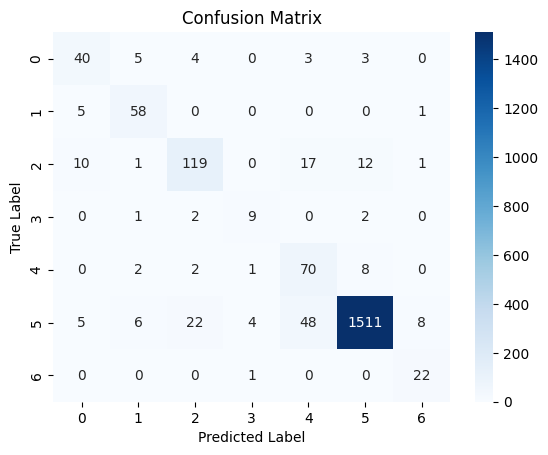

In [33]:
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), test_preds.argmax(axis=1))

# Create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Set the axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()


In [34]:
# Extract the row and column corresponding to class 4: mel
class_idx = 4
fn = conf_matrix[class_idx, :].sum() - conf_matrix[class_idx, class_idx]

# Calculate the percentage of instances from class 4 that were classified as another class
fn_percent = (fn / conf_matrix[class_idx, :].sum()) * 100

# Print the results
print(f"False Negative Rate for mel: {fn_percent:.2f}%")

False Negative Rate for mel: 15.66%
